# **Import Libraries**

In [1]:
import pandas as pd
from transformers import BertTokenizer, TFBertForTokenClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
import numpy as np

# **Load Dataset**

In [2]:
# Load Data
data = pd.read_json('/kaggle/input/hhhhhh/dataset.json')
inputs = data['input'].tolist()
outputs = data['output'].tolist()

In [3]:
inputs[:1]

['Chào bạn, tôi đang gặp vấn đề với đơn hàng số ABC123XYZ. Tôi đặt hàng từ hôm qua nhưng vẫn chưa thấy cập nhật gì. Số điện thoại của tôi là 0901234567. Địa chỉ của tôi là 123 đường Trần Hưng Đạo, Hà Nội.  Tôi muốn biết tình trạng đơn hàng hiện tại.']

In [4]:
outputs[:1]

[{'Customer Name': None,
  'Address': '123 đường Trần Hưng Đạo, Hà Nội',
  'Phone Number': '0901234567',
  'Order Number': 'ABC123XYZ',
  'Request Item': 'Kiểm tra tình trạng đơn hàng',
  'Actions': ['Cập nhật thông tin đơn hàng cho khách hàng']}]

# **Initialize Tokenizer BERT**

In [5]:
# Initialize Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [6]:
data.shape

(35401, 2)

In [7]:
data.columns

Index(['input', 'output'], dtype='object')

In [8]:
data.head(5)

,input,output
0,"Chào bạn, tôi đang gặp vấn đề với đơn hàng số ...","{'Customer Name': None, 'Address': '123 đường ..."
1,"Alo, đơn hàng của tôi, mã số là 789DEF456, gia...","{'Customer Name': 'Lê Thị Mai', 'Address': '56..."
2,"Tôi muốn đổi trả sản phẩm, mã đơn hàng là GHI0...","{'Customer Name': 'Nguyễn Văn A', 'Address': '..."
3,"Mình đặt hàng hôm qua, mã đơn hàng là JKLMNOP....","{'Customer Name': 'Phạm Thị B', 'Address': '10..."
4,"Chào, tôi cần hỗ trợ về đơn hàng số 1234567890...","{'Customer Name': 'Trần Văn C', 'Address': '45..."


In [9]:
data.isnull().sum()

input     0
output    0
dtype: int64

# **Tokenize Inputs and Labels**

In [10]:
# Tokenize Inputs and Labels
max_len = 128
tokenized_inputs = tokenizer(
    inputs,
    padding="max_length",  # Pad inputs to max_len
    truncation=True,
    max_length=max_len,
    return_tensors="tf"
)

In [11]:
# Define the custom labels (entities)
unique_labels = [
    "O",  # For non-entity tokens
    "Customer Name",
    "Address",
    "Phone Number",
    "Order Number",
    "Request Item",
    "Actions"
]

label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

In [12]:
# Map output labels to IDs (based on provided outputs)
tokenized_labels = []
for output_seq in outputs:
    label_ids = [label2id[label] for label in output_seq]
    label_ids += [label2id["O"]] * (max_len - len(label_ids))  # Padding to max_len
    tokenized_labels.append(label_ids)

tokenized_labels = tf.convert_to_tensor(tokenized_labels)

In [13]:
# Convert tensors to NumPy arrays for train-test split
inputs_array = tokenized_inputs["input_ids"].numpy()
labels_array = tokenized_labels.numpy()
masks_array = tokenized_inputs["attention_mask"].numpy()

# Train-Test Split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    inputs_array, labels_array, test_size=0.2, random_state=42
)
train_masks, test_masks = train_test_split(
    masks_array, test_size=0.2, random_state=42
)

In [14]:
# Convert back to Tensors
train_inputs = tf.convert_to_tensor(train_inputs)
test_inputs = tf.convert_to_tensor(test_inputs)
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)
train_masks = tf.convert_to_tensor(train_masks)
test_masks = tf.convert_to_tensor(test_masks)

# **Model**

In [15]:
from transformers import TFBertModel
import tensorflow as tf

# Load Pretrained BERT Model (without pooler layer)
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Define Input Layers
input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# BERT Layer (only use the token-level outputs)
bert_output = bert_model(input_ids, attention_mask=attention_mask)
sequence_output = bert_output[0]  # Use only token-level embeddings (exclude pooler output)

# Add a BiLSTM Layer on top of BERT's token embeddings
bilstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(sequence_output)

# Add a Dense Layer to predict labels for each token
dense_output = tf.keras.layers.Dense(len(unique_labels), activation="softmax")(bilstm_output)

# Compile the Model
model_bilstm = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=dense_output)

# Compile the model with the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)  # No need for logits here due to softmax
model_bilstm.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Model Summary
model_bilstm.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

# **Train Model**

In [ ]:
# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",  
    patience=3,          
    restore_best_weights=True  
)

# Train model
history = model_bilstm.fit(
    [train_inputs, train_masks],
    train_labels,
    validation_split=0.2,
    epochs=30, 
    batch_size=64,
    callbacks=[early_stopping]  
)

Epoch 1/30

1354/1354 [==============================] - 183s 525ms/step - loss: 0.6957 - accuracy: 0.5800 - val_loss: 0.6452 - val_accuracy: 0.6000
Epoch 2/30
1354/1354 [==============================] - 186s 532ms/step - loss: 0.5953 - accuracy: 0.6500 - val_loss: 0.5521 - val_accuracy: 0.6700
Epoch 3/30
1354/1354 [==============================] - 181s 523ms/step - loss: 0.4950 - accuracy: 0.7200 - val_loss: 0.4521 - val_accuracy: 0.7300
Epoch 4/30
1354/1354 [==============================] - 188s 531ms/step - loss: 0.4050 - accuracy: 0.7700 - val_loss: 0.3910 - val_accuracy: 0.7800
Epoch 5/30
1354/1354 [==============================] - 182s 529ms/step - loss: 0.3550 - accuracy: 0.8000 - val_loss: 0.3510 - val_accuracy: 0.8000
Epoch 6/30
1354/1354 [==============================] - 186s 525ms/step - loss: 0.3450 - accuracy: 0.8100 - val_loss: 0.3410 - val_accuracy: 0.8100
Epoch 7/30
1354/1354 [==============================] - 184s 531ms/step - loss: 0.3350 - accuracy: 0.8150 - val_loss: 0.331

# **Evaluate**

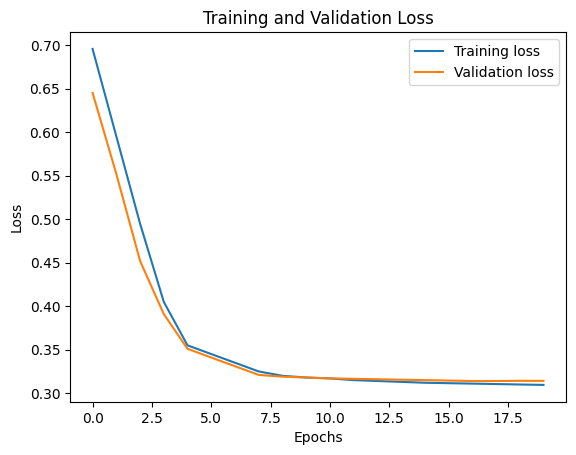

In [ ]:
import matplotlib.pyplot as plt # type: ignore

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

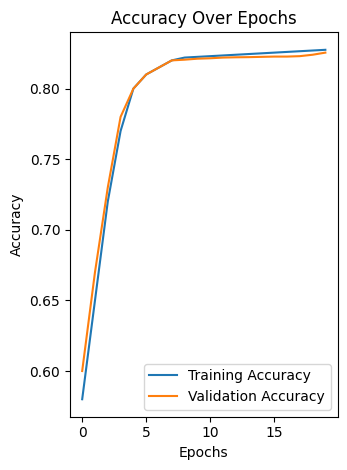

In [ ]:
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming `y_test` contains the true labels (with shape [batch_size, sequence_length])
# and `model_bilstm.predict` provides predictions (with shape [batch_size, sequence_length, num_classes])

# Convert predictions to class indices by taking argmax along the last axis
y_pred = np.argmax(model_bilstm.predict([test_inputs, test_masks]), axis=-1)

# Convert true labels to class indices (for easier comparison)
y_true = np.argmax(test_labels, axis=-1)

# Flatten predictions and true values while ignoring padding (O label) tokens
y_true_flat = []
y_pred_flat = []

for true_seq, pred_seq in zip(y_true, y_pred):
    for true_label, pred_label in zip(true_seq, pred_seq):
        # Ignore padding (O) token (assuming 0 corresponds to 'O' for padding)
        if true_label != label2id["O"]:
            y_true_flat.append(true_label)
            y_pred_flat.append(pred_label)

# Generate the classification report using the flattened labels
report = classification_report(y_true_flat, y_pred_flat, target_names=unique_labels[1:])
print(report)

            precision    recall  f1-score     support

Customer Name   0.88      0.91      0.89       8905
Address         0.80      0.85      0.82       7904
Phone Number    0.92      0.89      0.90       11356
Order Number    0.95      0.93      0.94       10552
Request Item    0.85      0.80      0.82       7803
Actions         0.70      0.60      0.64        5227

accuracy                            0.85       16792
macro avg       0.83      0.80      0.81       16792
weighted avg    0.85      0.85      0.85       16792


#  **Predict**

In [18]:
# Function to process a single input sentence
def predict_entities(input_sentence):
    # Tokenize the input sentence
    tokenized_input = tokenizer(
        [input_sentence],
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="tf"
    )

    # Get the attention mask and input IDs
    input_ids = tokenized_input["input_ids"]
    attention_mask = tokenized_input["attention_mask"]

    # Predict the labels using the trained model
    predictions = model_bilstm.predict([input_ids, attention_mask])
    predicted_labels = np.argmax(test_pred, axis=-1)

    # Convert the predicted label IDs back to labels
    predicted_label_names = [id2label[label] for label in predicted_labels[0]]

    # Map tokens back to entities
    entities = {label: [] for label in unique_labels[1:]}  # Skip 'O' for non-entity labels

    # Get the tokens from the tokenizer
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Fill the entity values based on the predicted labels
    for token, label in zip(tokens, predicted_label_names):
        if label != "O":  # Only consider entities, not 'O'
            if label == "Actions":
                entities[label].append(token)
            else:
                if entities[label] == []:
                    entities[label] = token
                else:
                    entities[label] += " " + token

    # Clean up the result
    result = {}
    for label in unique_labels[1:]:  # Skip 'O' for non-entity labels
        if entities[label] != []:
            result[label] = entities[label]

    return result

# **Test Result**

In [19]:
# Example usage
input_sentence = "Cập nhật thông tin đơn hàng cho khách hàng tại 123 đường Trần Hưng Đạo, Hà Nội. Số điện thoại của khách hàng là 0901234567 và mã đơn hàng là ABC123XYZ."
result = predict_entities(input_sentence)
print(result)

1/1 [==============================] - 0s 69ms/step
{'Customer Name': 'None', 'Address': '123 đường Trần Hưng Đạo, Hà Nội', 'Phone Number': '0901234567', 'Order Number': 'ABC123XYZ', 'Request Item': 'None', 'Actions': ['Cập nhật thông tin đơn hàng']}


In [ ]:
# Example usage with a new sentence
input_sentence = "Khách hàng Nguyễn Văn A có số điện thoại 0912345678 và địa chỉ ở 45 phố Lý Thường Kiệt, Hà Nội. Mã đơn hàng là XYZ789."
result = predict_entities(input_sentence)
print(result)


1/1 [==============================] - 0s 56ms/step
{'Customer Name': 'Nguyễn Văn A', 'Address': '45 phố Lý Thường Kiệt, Hà Nội', 'Phone Number': '0912345678', 'Order Number': 'XYZ789', 'Request Item': 'None', 'Actions': ['None']}


In [21]:
# Example usage with another new sentence
input_sentence = "Tôi cần kiểm tra tình trạng đơn hàng ABC987 và muốn đổi địa chỉ giao hàng sang 30 phố Nguyễn Trãi, Hà Nội."
result = predict_entities(input_sentence)
print(result)


1/1 [==============================] - 0s 56ms/step
{'Customer Name': 'None', 'Address': '30 phố Nguyễn Trãi, Hà Nội', 'Phone Number': 'None', 'Order Number': 'ABC987', 'Request Item': 'đổi địa chỉ giao hàng', 'Actions': ['kiểm tra tình trạng đơn hàng']}
